# genotyping using HMM

In [1]:
import numpy as np
import numpy.ma 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from snpmatch.core import parsers, genomes, genotype_cross, snp_genotype
import logging
log = logging.getLogger(__name__)

### provide input files

In [61]:
db_file = "/groups/nordborg/projects/field_experiments/007.pilot.sequencing/018.genotyping.by.plate/996.Swedes.220_6.newReSeq.July2020/002.mergeVCF/02_Swedes200_6.newReSeq_2.3M.BIALLELIC.hdf5"
input_vcf_file = "/groups/nordborg/projects/epiclines/005.manu.crosses.2020/004.design_resolved/snps_bcftools/f2_batchthree.maf_filtered.vcf.gz"
parents = "6046x6191_reSeq"

In [4]:
genome = genomes.Genome("athaliana_tair10")
g = snp_genotype.load_genotype_files( db_file )
geno_cross = genotype_cross.GenotypeCross(g, parents )


snpvcf = parsers.import_vcf_file(inFile =  input_vcf_file , logDebug = False, samples_to_load = None)
samples_ids = pd.Series(snpvcf['samples']) 
samples_gt = snpvcf['gt']
samples_gt = pd.DataFrame(samples_gt.astype(str))
input_chr_names = genome.chrs[pd.Series(snpvcf['chr'], dtype = str).apply(genome.get_chr_ind)]
g_chr_names = genome.chrs[pd.Series(geno_cross.commonSNPsCHR, dtype = str).apply(genome.get_chr_ind)]

In [20]:
def uniq_neighbor(a):
    sorted_a = np.array(a[0], dtype = a.dtype)
    sorted_a_count = np.array([1], dtype = int)
    for ef_ix in range(1, len(a)):
        if a[ef_ix] != a[ef_ix-1]:
            sorted_a = np.append(sorted_a, a[ef_ix])
            sorted_a_count = np.append(sorted_a_count, 1)
        elif a[ef_ix] == a[ef_ix-1]:
            sorted_a_count[-1] += 1
    return((sorted_a, sorted_a_count))
        
def get_parental_obs(input_gt, snpsP1_gt, snpsP2_gt, polarize = None):
    num_snps = len(input_gt)
    ebTarGTs = parsers.parseGT(input_gt)
    ebPolarised = np.zeros(num_snps, dtype=int)
    ### Here I am having 6 observed states. to consider SNPs where either of the parent shows -1 
    ## ('00', '01', '11', '0', '1', 'NA') 
    ##    0,    1,    2,   3,   4,    5
    ebPolarised[:] = 5
    snpsP1_gt_mask = numpy.ma.masked_less(numpy.ma.masked_greater(snpsP1_gt, 1), 0)
    snpsP2_gt_mask = numpy.ma.masked_less(numpy.ma.masked_greater(snpsP2_gt, 1), 0)
    ebPolarised[np.where((np.equal( ebTarGTs, snpsP1_gt_mask )) & (~snpsP2_gt_mask) )[0] ] = 0  ## 00
    ebPolarised[np.where((np.equal( ebTarGTs, snpsP1_gt_mask )) & (snpsP2_gt_mask) )[0] ] = 3 ## 0
    ebPolarised[np.where((np.equal( ebTarGTs, snpsP2_gt_mask )) & (~snpsP1_gt_mask) )[0] ] = 2  ## 11
    ebPolarised[np.where((np.equal( ebTarGTs, snpsP2_gt_mask )) & (snpsP1_gt_mask) )[0] ] = 4 ## 1
    ebPolarised[np.where((np.equal( ebTarGTs, np.repeat(2, num_snps) )) )[0] ] = 1
#     & ( ~snpsP1_gt_mask ) & (~snpsP2_gt_mask)
    return(ebPolarised)

def init_hmm(num_markers, chromosome_size = 115, recomb_rate = 3.3, n_iter = 100):
    """
    Function to initilize a HMM model 
    Input: 
        number of markers
        recomb_rate: assumed rate of recombination (cM per Mb)
        genome_size: size of chromosome in Mb
    """
    from hmmlearn import hmm
    ### The below transition probability is for a intercross, adapted from R/qtl
    log.info("Initialising HMM")
    states = ('aa', 'ab', 'bb')
    observations = ('00', '01', '11', '0', '1', 'NA')
    ## assume A. thaliana genome size of 115 Mb 
    ## First calculate the average spacing between the markers
    ## chromosome_size / num_markers 
    ##_____
    ## given a recombination rate of ~3.3 
    # probability you see a recombinant is 1 / (100 * recomb_rate)
    prob_of_change = ( chromosome_size / num_markers ) * ( 1 / (100 * recomb_rate)  )
    transmission_prob = [
            [1 - prob_of_change,  prob_of_change/2,   prob_of_change/2],
            [prob_of_change/2,    1 - prob_of_change, prob_of_change/2],
            [prob_of_change/2,    prob_of_change/2,   1 - prob_of_change]
    ]
    ## Since I have 6 possible observed states -- I have made an emmission matrix with such a structure.
    # Check Rqtl book page 381. Emission probabilities for intercross given error probability
    emission_prob = [ 
        [0.65,   0.1,  0.01,  0.5,  0.1,  0.33 ], 
        [0.34,    0.8,  0.34,    0.4,  0.4,  0.34 ],
        [0.01,  0.1,  0.65,   0.1,  0.5,  0.33 ]
    ]
    model = hmm.MultinomialHMM(n_components=3, n_iter = n_iter, algorithm = "viterbi") 
    model.startprob_ = np.array([0.25, 0.5, 0.25])
    model.transmat_ = pd.DataFrame(transmission_prob)
    model.emissionprob_ = pd.DataFrame(emission_prob)
    return(model)

In [7]:
np.where(samples_ids.values == 'T16_P1.A6_F2_D1')

(array([7]),)

In [58]:
t_chr_ix = 4
sample_ix = 3

ec = genome.chrs[t_chr_ix] 
eclen = genome.chrlen[t_chr_ix]

reqPOSind =  np.where( g_chr_names == ec)[0]
reqTARind = np.where( input_chr_names == ec )[0]
ebAccsInds, ebTarInds = geno_cross._get_common_positions_ixs(geno_cross.commonSNPsPOS, snpvcf['pos'], reqPOSind, reqTARind)

t_genotypes_raw = get_parental_obs(samples_gt.iloc[ebTarInds,sample_ix].values, geno_cross.snpsP1[ebAccsInds], geno_cross.snpsP2[ebAccsInds])

model = init_hmm( samples_gt.shape[0] )
# model = model.fit(t_genotypes_raw.reshape((-1, 1)),  )
t_genotypes = model.decode(t_genotypes_raw.reshape((-1, 1)), algorithm='viterbi')
# model.predict(t_genotypes_raw.reshape((-1, 1)))
# np.array_equal(t_genotypes[1], model.predict(t_genotypes_raw.reshape((-1, 1))))

In [53]:
t_genotypes[0]

-2054.688554078723

In [55]:
uniq_neighbor( t_genotypes[1] )

(array([1, 0, 1, 2, 1]), array([689, 964, 456, 165,  53]))

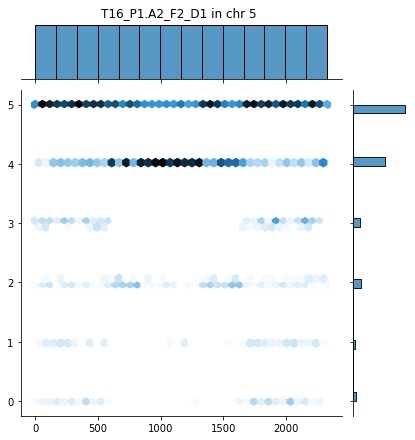

In [59]:
p = sns.jointplot(np.arange(t_genotypes_raw.shape[0]), t_genotypes_raw, kind="hex", joint_kws=dict(gridsize=40))


p.ax_marg_x.set_title( "%s in chr %s " % (samples_ids.values[sample_ix], ec) )
plt.show()

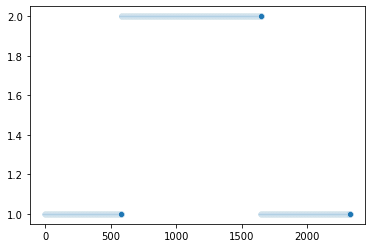

In [60]:
sns.scatterplot(np.arange(t_genotypes[1].shape[0]), t_genotypes[1] )